# Project: Part of Speech Tagging with Hidden Markov Models 
---
### Introduction

Part of speech tagging is the process of determining the syntactic category of a word from the words in its surrounding context. It is often used to help disambiguate natural language phrases because it can be done quickly with high accuracy. Tagging can be used for many NLP tasks like determining correct pronunciation during speech synthesis (for example, _dis_-count as a noun vs dis-_count_ as a verb), for information retrieval, and for word sense disambiguation.

In this notebook, we explore the Pomegranate API and use the [Pomegranate](http://pomegranate.readthedocs.io/) library to build a hidden Markov model for part of speech tagging using a "universal" tagset. Hidden Markov models have been able to achieve [>96% tag accuracy with larger tagsets on realistic text corpora](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf). Hidden Markov models have also been used for speech recognition and speech generation, machine translation, gene recognition for bioinformatics, and human gesture recognition for computer vision, and more. 

### The Road Ahead

- [Step 0](#Step-0:-Build-a-Simple-HMM-model-and-explore-the-Pomegranate-library): Build a Simple HMM model and explore the Pomegranate library
- [Step 1](#Step-1:-Read-and-preprocess-the-dataset): Review the provided interface to load and access the text corpus
- [Step 2](#Step-2:-Build-a-Most-Frequent-Class-tagger): Build a Most Frequent Class tagger to use as a baseline
- [Step 3](#Step-3:-Build-an-HMM-tagger): Build an HMM Part of Speech tagger and compare to the MFC baseline
- [Step 4](#Step-4:-[Optional]-Improving-model-performance): (Optional) Improve the HMM tagger

In [1]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%autoreload 1

In [2]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np

from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## Build a Simple HMM
---
We start by building a simple HMM network based on an example from the textbook [Artificial Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/).

> You are the security guard stationed at a secret under-ground installation. Each day, you try to guess whether it’s raining today, but your only access to the outside world occurs each morning when you see the director coming in with, or without, an umbrella.

A simplified diagram of the required network topology is shown below.

![](_example.png)

### Describing the Network

<div class="alert alert-block alert-warning">
$\lambda = (A, B)$ specifies a Hidden Markov Model in terms of an emission probability distribution $A$ and a state transition probability distribution $B$.
</div>

HMM networks are parameterized by two distributions: the emission probabilties giving the conditional probability of observing evidence values for each hidden state, and the transition probabilities giving the conditional probability of moving between states during the sequence. Additionally, we can specify an initial distribution describing the probability of a sequence starting in each state.

<div class="alert alert-block alert-warning">
At each time $t$, $X_t$ represents the hidden state, and $Y_t$ represents an observation at that time.
</div>

In this problem, $t$ corresponds to each day of the week and the hidden state represent the weather outside (whether it is Rainy or Sunny) and observations record whether the security guard sees the director carrying an umbrella or not.

For example, during some particular week the guard may observe an umbrella ['yes', 'no', 'yes', 'no', 'yes'] on Monday-Friday, while the weather outside is ['Rainy', 'Sunny', 'Sunny', 'Sunny', 'Rainy']. In that case, $t=Wednesday$, $Y_{Wednesday}=yes$, and $X_{Wednesday}=Sunny$. (It might be surprising that the guard would observe an umbrella on a sunny day, but it is possible under this type of model.)

### Initializing an HMM Network with Pomegranate
The Pomegranate library supports [two initialization methods](http://pomegranate.readthedocs.io/en/latest/HiddenMarkovModel.html#initialization). We can either explicitly provide the three distributions, or we can build the network line-by-line. We'll use the line-by-line method for the example network

In [3]:
# create the HMM model
model = HiddenMarkovModel(name="Example Model")

### Add the Hidden States
When the HMM model is specified line-by-line, the object starts as an empty container. The first step is to name each state and attach an emission distribution.

#### Observation Emission Probabilities: $P(Y_t | X_t)$
We need to assume that we have some prior knowledge (possibly from a data set) about the director's behavior to estimate the emission probabilities for each hidden state. In real problems we often estimate the emission probabilities empirically, which is what we'll do for the part of speech tagger. Our imaginary data will produce the conditional probability table below. (Note that the rows sum to 1.0)

| |  $yes$  | $no$ |
| --- | --- | --- |
| $Sunny$ |   0.10  | 0.90 |
| $Rainy$ | 0.80 | 0.20 |

In [4]:
# create the HMM model
model = HiddenMarkovModel(name="Example Model")

# emission probability distributions, P(umbrella | weather)
sunny_emissions = DiscreteDistribution({"yes": 0.1, "no": 0.9})
sunny_state = State(sunny_emissions, name="Sunny")

#create a discrete distribution for the rainy emissions from the probability table
# above & use that distribution to create a state named Rainy
rainy_emissions = DiscreteDistribution({"yes": 0.8, "no": 0.2})
rainy_state = State(rainy_emissions, name="Rainy")

# add the states to the model
model.add_states(sunny_state, rainy_state)

assert rainy_emissions.probability("yes") == 0.8, "The director brings his umbrella with probability 0.8 on rainy days"
print("Looks good so far!")

Looks good so far!


###  Adding Transitions
Once the states are added to the model, we can build up the desired topology of individual state transitions.

#### Initial Probability $P(X_0)$:
We will assume that we don't know anything useful about the likelihood of a sequence starting in either state. If the sequences start each week on Monday and end each week on Friday (so each week is a new sequence), then this assumption means that it's equally likely that the weather on a Monday may be Rainy or Sunny. We can assign equal probability to each starting state by setting $P(X_0=Rainy) = 0.5$ and $P(X_0=Sunny)=0.5$:

| $Sunny$ | $Rainy$ |
| --- | ---
| 0.5 | 0.5 |

#### State transition probabilities $P(X_{t} | X_{t-1})$
Finally, we will assume for this example that we can estimate transition probabilities from something like historical weather data for the area. In real problems we can often use the structure of the problem (like a language grammar) to impose restrictions on the transition probabilities, then re-estimate the parameters with the same training data used to estimate the emission probabilities. Under this assumption, we get the conditional probability table below. (Note that the rows sum to 1.0)

| | $Sunny$ | $Rainy$ |
| --- | --- | --- |
|$Sunny$| 0.80 | 0.20 |
|$Rainy$| 0.40 | 0.60 |

In [5]:
# create edges for each possible state transition in the model
# equal probability of a sequence starting on either a rainy or sunny day
model.add_transition(model.start, sunny_state, 0.5)
model.add_transition(model.start, rainy_state, 0.5)

# add sunny day transitions (we already know estimates of these probabilities
# from the problem statement)
model.add_transition(sunny_state, sunny_state, 0.8)  # 80% sunny->sunny
model.add_transition(sunny_state, rainy_state, 0.2)  # 20% sunny->rainy

# add rainy day transitions using the probabilities specified in the transition table
model.add_transition(rainy_state, sunny_state, 0.4)  # 40% rainy->sunny
model.add_transition(rainy_state, rainy_state, 0.6)  # 60% rainy->rainy

# finally, call the .bake() method to finalize the model
model.bake()

assert model.edge_count() == 6, "There should be two edges from model.start, two from Rainy, and two from Sunny"
assert model.node_count() == 4, "The states should include model.start, model.end, Rainy, and Sunny"
print("Great! You've finished the model.")

Great! You've finished the model.


## Visualize the Network
---
We have provided a helper function called `show_model()` that generates a PNG image from a Pomegranate HMM network. We can specify an optional filename to save the file to disk. Setting the "show_ends" argument True will add the model start & end states that are included in every Pomegranate network.

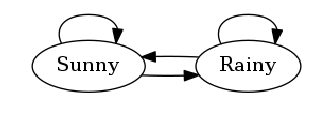

In [6]:
show_model(model, figsize=(5, 5), filename="example.png", overwrite=True, show_ends=False)

### Checking the Model
The states of the model can be accessed using array syntax on the `HMM.states` attribute, and the transition matrix can be accessed by calling `HMM.dense_transition_matrix()`. Element $(i, j)$ encodes the probability of transitioning from state $i$ to state $j$. For example, with the default column order specified, element $(2, 1)$ gives the probability of transitioning from "Rainy" to "Sunny", which we specified as 0.4.

Run the next cell to inspect the full state transition matrix, then read the . 

In [7]:
column_order = ["Example Model-start", "Sunny", "Rainy", "Example Model-end"]  # Override the Pomegranate default order
column_names = [s.name for s in model.states]
order_index = [column_names.index(c) for c in column_order]

# re-order the rows/columns to match the specified column order
transitions = model.dense_transition_matrix()[:, order_index][order_index, :]
print("The state transition matrix, P(Xt|Xt-1):\n")
print(transitions)
print("\nThe transition probability from Rainy to Sunny is {:.0f}%".format(100 * transitions[2, 1]))

The state transition matrix, P(Xt|Xt-1):

[[ 0.   0.5  0.5  0. ]
 [ 0.   0.8  0.2  0. ]
 [ 0.   0.4  0.6  0. ]
 [ 0.   0.   0.   0. ]]

The transition probability from Rainy to Sunny is 40%


## Inference in Hidden Markov Models
---
Before moving on, we'll use this simple network to quickly go over the Pomegranate API to perform the three most common HMM tasks:

<div class="alert alert-block alert-info">
**Likelihood Evaluation**<br>
Given a model $\lambda=(A,B)$ and a set of observations $Y$, determine $P(Y|\lambda)$, the likelihood of observing that sequence from the model
</div>

We can use the weather prediction model to evaluate the likelihood of the sequence [yes, yes, yes, yes, yes] (or any other state sequence). The likelihood is often used in problems like machine translation to weight interpretations in conjunction with a statistical language model.

<div class="alert alert-block alert-info">
**Hidden State Decoding**<br>
Given a model $\lambda=(A,B)$ and a set of observations $Y$, determine $Q$, the most likely sequence of hidden states in the model to produce the observations
</div>

We can use the weather prediction model to determine the most likely sequence of Rainy/Sunny states for a known observation sequence, like [yes, no] -> [Rainy, Sunny]. We will use decoding in the part of speech tagger to determine the tag for each word of a sentence. The decoding can be further split into "smoothing" when we want to calculate past states, "filtering" when we want to calculate the current state, or "prediction" if we want to calculate future states. 

<div class="alert alert-block alert-info">
**Parameter Learning**<br>
Given a model topography (set of states and connections) and a set of observations $Y$, learn the transition probabilities $A$ and emission probabilities $B$ of the model, $\lambda=(A,B)$
</div>

We don't need to learn the model parameters for the weather problem or POS tagging, but it is supported by Pomegranate.

### Calculate Sequence Likelihood

Calculating the likelihood of an observation sequence from an HMM network is performed with the [forward algorithm](https://en.wikipedia.org/wiki/Forward_algorithm). Pomegranate provides the the `HMM.forward()` method to calculate the full matrix showing the likelihood of aligning each observation to each state in the HMM, and the `HMM.log_probability()` method to calculate the cumulative likelihood over all possible hidden state paths that the specified model generated the observation sequence.

Fill in the code in the next section with a sample observation sequence and then use the `forward()` and `log_probability()` methods to evaluate the sequence.

In [8]:
# input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

assert len(observations) > 0, "You need to choose a sequence of 'yes'/'no' observations to test"

# use model.forward() to calculate the forward matrix of the observed sequence,
# and then use np.exp() to convert from log-likelihood to likelihood
forward_matrix = np.exp(model.forward(observations))

# use model.log_probability() to calculate the all-paths likelihood of the
# observed sequence and then use np.exp() to convert log-likelihood to likelihood
probability_percentage = np.exp(model.log_probability(observations))

# Display the forward probabilities
print("         " + "".join(s.name.center(len(s.name)+6) for s in model.states))
for i in range(len(observations) + 1):
    print(" <start> " if i==0 else observations[i - 1].center(9), end="")
    print("".join("{:.0f}%".format(100 * forward_matrix[i, j]).center(len(s.name) + 6)
                  for j, s in enumerate(model.states)))

print("\nThe likelihood over all possible paths " + \
      "of this model producing the sequence {} is {:.2f}%\n\n"
      .format(observations, 100 * probability_percentage))

            Rainy      Sunny      Example Model-start      Example Model-end   
 <start>      0%         0%               100%                     0%          
   yes       40%         5%                0%                      0%          
    no        5%        18%                0%                      0%          
   yes        5%         2%                0%                      0%          

The likelihood over all possible paths of this model producing the sequence ['yes', 'no', 'yes'] is 6.92%




### Decoding the Most Likely Hidden State Sequence

The [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) calculates the single path with the highest likelihood to produce a specific observation sequence. Pomegranate provides the `HMM.viterbi()` method to calculate both the hidden state sequence and the corresponding likelihood of the viterbi path.

This is called "decoding" because we use the observation sequence to decode the corresponding hidden state sequence. In the part of speech tagging problem, the hidden states map to parts of speech and the observations map to sentences. Given a sentence, Viterbi decoding finds the most likely sequence of part of speech tags corresponding to the sentence.

We use the same sample observation sequence as used above, and then use the `model.viterbi()` method to calculate the likelihood and most likely state sequence. We compare the Viterbi likelihood against the forward algorithm likelihood for the observation sequence.

In [9]:
# input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

# use model.viterbi to find the sequence likelihood & the most likely path
viterbi_likelihood, viterbi_path = model.viterbi(observations)

print("The most likely weather sequence to have generated " + \
      "these observations is {} at {:.2f}%."
      .format([s[1].name for s in viterbi_path[1:]], np.exp(viterbi_likelihood)*100)
)

The most likely weather sequence to have generated these observations is ['Rainy', 'Sunny', 'Rainy'] at 2.30%.


### Forward likelihood vs Viterbi likelihood
Run the cells below to see the likelihood of each sequence of observations with length 3, and compare with the viterbi path.

In [10]:
from itertools import product

observations = ['no', 'no', 'yes']

p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is...".format(o))
for s in product(*[['Sunny', 'Rainy']]*3):
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

The likelihood of observing ['no', 'no', 'yes'] if the weather sequence is...
	('Sunny', 'Sunny', 'Sunny') is 2.59% 
	('Sunny', 'Sunny', 'Rainy') is 5.18%  <-- Viterbi path
	('Sunny', 'Rainy', 'Sunny') is 0.07% 
	('Sunny', 'Rainy', 'Rainy') is 0.86% 
	('Rainy', 'Sunny', 'Sunny') is 0.29% 
	('Rainy', 'Sunny', 'Rainy') is 0.58% 
	('Rainy', 'Rainy', 'Sunny') is 0.05% 
	('Rainy', 'Rainy', 'Rainy') is 0.58% 

The total likelihood of observing ['no', 'no', 'yes'] over all possible paths is 10.20%


## Step 1: Read and preprocess the dataset
---
We'll start by reading in a text corpus and splitting it into a training and testing dataset. The data set is a copy of the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) (originally from the [NLTK](https://www.nltk.org/) library) that has already been pre-processed to only include the [universal tagset](https://arxiv.org/pdf/1104.2086.pdf). We should expect to get slightly higher accuracy using this simplified tagset than the same model would achieve on a larger tagset like the full [Penn treebank tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html), but the process we follow would be the same.

The `Dataset` class provided in helpers.py will read and parse the corpus. We can generate our own datasets compatible with the reader by writing them to the following format. The dataset is stored in plaintext as a collection of words and corresponding tags. Each sentence starts with a unique identifier on the first line, followed by one tab-separated word/tag pair on each following line. Sentences are separated by a single blank line.

Example from the Brown corpus. 
```
b100-38532
Perhaps	ADV
it	PRON
was	VERB
right	ADJ
;	.
;	.

b100-35577
...
```

In [11]:
data = Dataset("tags-universal.txt", "brown-universal.txt", train_test_split=0.8)

print("There are {} sentences in the corpus.".format(len(data)))
print("There are {} sentences in the training set.".format(len(data.training_set)))
print("There are {} sentences in the testing set.".format(len(data.testing_set)))

There are 57340 sentences in the corpus.
There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


### The Dataset Interface

We can access (mostly) immutable references to the dataset through a simple interface provided through the `Dataset` class, which represents an iterable collection of sentences along with easy access to partitions of the data for training & testing. 

```
Dataset-only Attributes:
    training_set - reference to a Subset object containing the samples for training
    testing_set - reference to a Subset object containing the samples for testing

Dataset & Subset Attributes:
    sentences - a dictionary with an entry {sentence_key: Sentence()} for each sentence in the corpus
    keys - an immutable ordered (not sorted) collection of the sentence_keys for the corpus
    vocab - an immutable collection of the unique words in the corpus
    tagset - an immutable collection of the unique tags in the corpus
    X - returns an array of words grouped by sentences ((w11, w12, w13, ...), (w21, w22, w23, ...), ...)
    Y - returns an array of tags grouped by sentences ((t11, t12, t13, ...), (t21, t22, t23, ...), ...)
    N - returns the number of distinct samples (individual words or tags) in the dataset

Methods:
    stream() - returns an flat iterable over all (word, tag) pairs across all sentences in the corpus
    __iter__() - returns an iterable over the data as (sentence_key, Sentence()) pairs
    __len__() - returns the nubmer of sentences in the dataset
```

For example, consider a Subset, `subset`, of the sentences `{"s0": Sentence(("See", "Spot", "run"), ("VERB", "NOUN", "VERB")), "s1": Sentence(("Spot", "ran"), ("NOUN", "VERB"))}`. The subset will have these attributes:

```
subset.keys == {"s1", "s0"}  # unordered
subset.vocab == {"See", "run", "ran", "Spot"}  # unordered
subset.tagset == {"VERB", "NOUN"}  # unordered
subset.X == (("Spot", "ran"), ("See", "Spot", "run"))  # order matches .keys
subset.Y == (("NOUN", "VERB"), ("VERB", "NOUN", "VERB"))  # order matches .keys
subset.N == 7  # there are a total of seven observations over all sentences
len(subset) == 2  # because there are two sentences
```


#### Sentences

`Dataset.sentences` is a dictionary of all sentences in the training corpus, each keyed to a unique sentence identifier. Each `Sentence` is itself an object with two attributes: a tuple of the words in the sentence named `words` and a tuple of the tag corresponding to each word named `tags`.

In [12]:
key = 'b100-38532'
print("Sentence: {}".format(key))
print("words:\n\t{!s}".format(data.sentences[key].words))
print("tags:\n\t{!s}".format(data.sentences[key].tags))

Sentence: b100-38532
words:
	('Perhaps', 'it', 'was', 'right', ';', ';')
tags:
	('ADV', 'PRON', 'VERB', 'ADJ', '.', '.')


<div class="alert alert-block alert-info">
**Note:** The underlying iterable sequence is **unordered** over the sentences in the corpus; it is not guaranteed to return the sentences in a consistent order between calls. We use `Dataset.stream()`, `Dataset.keys`, `Dataset.X`, or `Dataset.Y` attributes if we need ordered access to the data.
</div>

#### Counting Unique Elements

We can access the list of unique words (the dataset vocabulary) via `Dataset.vocab` and the unique list of tags via `Dataset.tagset`.

In [13]:
print("There are a total of {} samples of {} unique words in the corpus."
      .format(data.N, len(data.vocab)))
print("There are {} samples of {} unique words in the training set."
      .format(data.training_set.N, len(data.training_set.vocab)))
print("There are {} samples of {} unique words in the testing set."
      .format(data.testing_set.N, len(data.testing_set.vocab)))
print("There are {} words in the test set that are missing in the training set."
      .format(len(data.testing_set.vocab - data.training_set.vocab)))

There are a total of 1161192 samples of 56057 unique words in the corpus.
There are 928458 samples of 50536 unique words in the training set.
There are 232734 samples of 25112 unique words in the testing set.
There are 5521 words in the test set that are missing in the training set.


#### Accessing word and tag Sequences
The `Dataset.X` and `Dataset.Y` attributes provide access to ordered collections of matching word and tag sequences for each sentence in the dataset.

In [14]:
# accessing words with Dataset.X and tags with Dataset.Y 
for i in range(2):    
    print("Sentence {}:".format(i + 1), data.X[i])
    print()
    print("Labels {}:".format(i + 1), data.Y[i])
    print()

Sentence 1: ('Mr.', 'Podger', 'had', 'thanked', 'him', 'gravely', ',', 'and', 'now', 'he', 'made', 'use', 'of', 'the', 'advice', '.')

Labels 1: ('NOUN', 'NOUN', 'VERB', 'VERB', 'PRON', 'ADV', '.', 'CONJ', 'ADV', 'PRON', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', '.')

Sentence 2: ('But', 'there', 'seemed', 'to', 'be', 'some', 'difference', 'of', 'opinion', 'as', 'to', 'how', 'far', 'the', 'board', 'should', 'go', ',', 'and', 'whose', 'advice', 'it', 'should', 'follow', '.')

Labels 2: ('CONJ', 'PRT', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADP', 'ADV', 'ADV', 'DET', 'NOUN', 'VERB', 'VERB', '.', 'CONJ', 'DET', 'NOUN', 'PRON', 'VERB', 'VERB', '.')



#### Accessing (word, tag) Samples
The `Dataset.stream()` method returns an iterator that chains together every pair of (word, tag) entries across all sentences in the entire corpus.

In [15]:
# use Dataset.stream() (word, tag) samples for the entire corpus
print("\nStream (word, tag) pairs:\n")
for i, pair in enumerate(data.stream()):
    print("\t", pair)
    if i > 5: break


Stream (word, tag) pairs:

	 ('Mr.', 'NOUN')
	 ('Podger', 'NOUN')
	 ('had', 'VERB')
	 ('thanked', 'VERB')
	 ('him', 'PRON')
	 ('gravely', 'ADV')
	 (',', '.')



For both our baseline tagger and the HMM model we'll build, we need to estimate the frequency of tags & words from the frequency counts of observations in the training corpus. In the next several cells you will complete functions to compute the counts of several sets of counts. 

## Step 2: Build a Most Frequent Class tagger
---

Perhaps the simplest tagger (and a good baseline for tagger performance) is to simply choose the tag most frequently assigned to each word. This "most frequent class" tagger inspects each observed word in the sequence and assigns it the label that was most often assigned to that word in the corpus.

### Pair Counts

The function below computes the joint frequency counts for two input sequences.

In [16]:
from IPython.display import HTML
def pair_counts(sequences_A, sequences_B):
    """Return a dictionary keyed to each unique value in the first sequence list
    that counts the number of occurrences of the corresponding value from the
    second sequences list.
    
    For example, if sequences_A is tags and sequences_B is the corresponding
    words, then if 1244 sequences contain the word "time" tagged as a NOUN, then
    you should return a dictionary such that pair_counts[NOUN][time] == 1244
    """
    
    result = {}
    index = 0;
    for tag in sequences_A:
        word = sequences_B[index]
        if not tag in result:
            result[tag] = {}
        if not word in result[tag]:
            result[tag][word]=0
        result[tag][word]+=1
        index+=1
    return result 


# Calculate C(t_i, w_i)
tags = [tag for _, tag in data.training_set.stream()]
words = [word for word, _ in data.training_set.stream()]
emission_counts = pair_counts(tags,words)

### Most Frequent Class Tagger

We use `pair_counts()` function and the training dataset to find the most frequent class label for each word in the training data, and populate the `mfc_table` below. The table keys should be words, and the values should be the appropriate tag string.

The `MFCTagger` class is provided to mock the interface of Pomegranite HMM models so that they can be used interchangeably.

In [17]:
# Create a lookup table mfc_table where mfc_table[word] contains the tag label most frequently assigned to that word
from collections import namedtuple

FakeState = namedtuple("FakeState", "name")

class MFCTagger:
    missing = FakeState(name="<MISSING>")
    
    def __init__(self, table):
        self.table = defaultdict(lambda: MFCTagger.missing)
        self.table.update({word: FakeState(name=tag) for word, tag in table.items()})
        
    def viterbi(self, seq):
        """This method simplifies predictions by matching the Pomegranate viterbi() interface"""
        return 0., list(enumerate(["<start>"] + [self.table[w] for w in seq] + ["<end>"]))


# calculate the frequency of each tag being assigned to each word (similar, but not
# the same as the emission probabilities) and use it to fill the mfc_table

word_counts = pair_counts(words, tags)

mfc_table = {}
for word, tag_set in word_counts.items():
    #find tag with maximum value
    current_max = 0
    for tag_name, tag_count in tag_set.items():
        if tag_count > current_max:
            current_max = tag_count
            tag_with_max_count = tag_name
    mfc_table[word] = tag_with_max_count

mfc_model = MFCTagger(mfc_table) # Create a Most Frequent Class tagger instance

### Making Predictions with a Model
The helper functions provided below interface with Pomegranate network models & the mocked MFCTagger to take advantage of the [missing value](http://pomegranate.readthedocs.io/en/latest/nan.html) functionality in Pomegranate through a simple sequence decoding function. 

In [18]:
def replace_unknown(sequence):
    """Return a copy of the input sequence where each unknown word is replaced
    by the literal string value 'nan'. Pomegranate will ignore these values
    during computation.
    """
    return [w if w in data.training_set.vocab else 'nan' for w in sequence]

def simplify_decoding(X, model):
    """X should be a 1-D sequence of observations for the model to predict"""
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]  # do not show the start/end state predictions

### Example Decoding Sequences with MFC Tagger

In [19]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, mfc_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', '<MISSING>', 'ADP', 'ADJ', 'ADJ', 

### Evaluating Model Accuracy

The function below will evaluate the accuracy of the MFC tagger on the collection of all sentences from a text corpus. 

In [20]:
def accuracy(X, Y, model):
    """Calculate the prediction accuracy by using the model to decode each sequence
    in the input X and comparing the prediction with the true labels in Y.
    
    The X should be an array whose first dimension is the number of sentences to test,
    and each element of the array should be an iterable of the words in the sequence.
    The arrays X and Y should have the exact same shape.
    
    X = [("See", "Spot", "run"), ("Run", "Spot", "run", "fast"), ...]
    Y = [(), (), ...]
    """
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        
        # The model.viterbi call in simplify_decoding will return None if the HMM
        # raises an error (for example, if a test sentence contains a word that
        # is out of vocabulary for the training set). Any exception counts the
        # full sentence as an error (which makes this a conservative estimate).
        try:
            most_likely_tags = simplify_decoding(observations, model)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions

#### Evaluate the accuracy of the MFC tagger
We evaluate the accuracy of the tagger on the training and test corpus.

In [21]:
mfc_training_acc = accuracy(data.training_set.X, data.training_set.Y, mfc_model)
print("training accuracy mfc_model: {:.2f}%".format(100 * mfc_training_acc))

mfc_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, mfc_model)
print("testing accuracy mfc_model: {:.2f}%".format(100 * mfc_testing_acc))


training accuracy mfc_model: 95.72%
testing accuracy mfc_model: 93.01%


## Step 3: Build an HMM tagger
---
The HMM tagger has one hidden state for each possible tag, and parameterized by two distributions: the emission probabilties giving the conditional probability of observing a given **word** from each hidden state, and the transition probabilities giving the conditional probability of moving between **tags** during the sequence.

We will also estimate the starting probability distribution (the probability of each **tag** being the first tag in a sequence), and the terminal probability distribution (the probability of each **tag** being the last tag in a sequence).

The maximum likelihood estimate of these distributions can be calculated from the frequency counts as described in the following sections where you'll implement functions to count the frequencies, and finally build the model. The HMM model will make predictions according to the formula:

$$t_i^n = \underset{t_i^n}{\mathrm{argmin}} \prod_{i=1}^n P(w_i|t_i) P(t_i|t_{i-1})$$


### Unigram Counts

Below we estimate the co-occurrence frequency of each symbol over all of the input sequences. The unigram probabilities in our HMM model are estimated from the formula below, where N is the total number of samples in the input. (You only need to compute the counts for now.)

$$P(tag_1) = \frac{C(tag_1)}{N}$$

In [22]:
def unigram_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequence list that
    counts the number of occurrences of the value in the sequences list. The sequences
    collection should be a 2-dimensional array.
    
    For example, if the tag NOUN appears 275558 times over all the input sequences,
    then you should return a dictionary such that your_unigram_counts[NOUN] == 275558.
    """
    # Finish this function!
    result = {}
    for sequence in sequences:
        for tag in sequence:
            if not tag in result:
                result[tag]=0
            result[tag]+=1
    return result

# call unigram_counts with a list of tag sequences from the training set
tag_unigrams = unigram_counts(data.training_set.Y)

### Bigram Counts

We estimate the co-occurrence frequency of each pair of symbols in each of the input sequences. These counts are used in the HMM model to estimate the bigram probability of two tags from the frequency counts according to the formula: $$P(tag_2|tag_1) = \frac{C(tag_2|tag_1)}{C(tag_2)}$$


In [23]:
def bigram_counts(sequences):
    """Return a dictionary keyed to each unique PAIR of values in the input sequences
    list that counts the number of occurrences of pair in the sequences list. The input
    should be a 2-dimensional array.
    
    For example, if the pair of tags (NOUN, VERB) appear 61582 times, then you should
    return a dictionary such that your_bigram_counts[(NOUN, VERB)] == 61582
    """

    # Finish this function!
    result = {}
    for sequence in sequences:
        if len(sequence) > 1:
            for idx in range(1,len(sequence)):
                bigram = (sequence[idx-1],sequence[idx])
                if not bigram in result:
                    result[bigram]=0
                result[bigram]+=1
    return result

# call bigram_counts with a list of tag sequences from the training set
tag_bigrams = bigram_counts(data.training_set.Y)


### Sequence Starting Counts
We estimate the bigram probabilities of a sequence starting with each tag.

In [24]:
def starting_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the beginning of
    a sequence.
    
    For example, if 8093 sequences start with NOUN, then you should return a
    dictionary such that your_starting_counts[NOUN] == 8093
    """
    # TODO: Finish this function!
    result = {}
    for sequence in sequences:
        start_tag = sequence[0]
        if not start_tag in result:
            result[start_tag]=0
        result[start_tag]+=1
    return result

# Calculate the count of each tag starting a sequence
tag_starts = starting_counts(data.training_set.Y)


### IMPLEMENTATION: Sequence Ending Counts
Complete the function below to estimate the bigram probabilities of a sequence ending with each tag.

In [25]:
def ending_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the end of
    a sequence.
    
    For example, if 18 sequences end with DET, then you should return a
    dictionary such that your_starting_counts[DET] == 18
    """
    # Finish this function!
    result = {}
    for sequence in sequences:
        end_tag = sequence[-1]
        if not end_tag in result:
            result[end_tag]=0
        result[end_tag]+=1
    return result

# Calculate the count of each tag ending a sequence
tag_ends = ending_counts(data.training_set.Y)

### Basic HMM Tagger
We use the tag unigrams and bigrams calculated above to construct a hidden Markov tagger.

- Add one state per tag
    - The emission distribution at each state should be estimated with the formula: $P(w|t) = \frac{C(t, w)}{C(t)}$
- Add an edge from the starting state `basic_model.start` to each tag
    - The transition probability should be estimated with the formula: $P(t|start) = \frac{C(start, t)}{C(start)}$
- Add an edge from each tag to the end state `basic_model.end`
    - The transition probability should be estimated with the formula: $P(end|t) = \frac{C(t, end)}{C(t)}$
- Add an edge between _every_ pair of tags
    - The transition probability should be estimated with the formula: $P(t_2|t_1) = \frac{C(t_1, t_2)}{C(t_1)}$

In [26]:
basic_model = HiddenMarkovModel(name="base-hmm-tagger")

# create states with emission probability distributions P(word | tag) and add to the model
# We add loop & create/add new states)
states = {}
# calculate outside of loop for efficiency
sum_of_start_values_counts = sum(tag_starts.values())
sum_of_end_values_counts = sum(tag_ends.values())

for tag in data.tagset:
    emission_probabilities = {word: count / tag_unigrams[tag] for word, count in emission_counts[tag].items()}
    tag_distribution = DiscreteDistribution(emission_probabilities)
    s=State(tag_distribution, name=tag)
    states[tag]=s
    basic_model.add_state(s)
    # add the start and end transitions / probabilities
    start_proba = tag_starts[tag]/sum_of_start_values_counts
    end_proba = tag_ends[tag]/sum_of_end_values_counts
    basic_model.add_transition(basic_model.start, s, start_proba)
    basic_model.add_transition(s, basic_model.end, end_proba)


# add edges between states for the observed transition frequencies P(tag_i | tag_i-1)
# we add loop & add transitions
for tag1 in data.tagset:
    tag1_state = states[tag1]
    # prob_sum of all transition probabilities must be near to 1.0 at the end (assert / check)
    prob_sum = 0
    for tag2 in data.tagset:
        tag2_state = states[tag2]
        bigram = (tag1,tag2)
        transition_probability = tag_bigrams[bigram]/tag_unigrams[tag1]
        prob_sum+=transition_probability
        basic_model.add_transition(tag1_state, tag2_state, transition_probability)
    # check sum of transition probabilities. "." is allowed to have lower probability sum because it is often followed by end state
    if tag1 != '.':
        assert prob_sum > 0.994 and prob_sum <= 1.0, "transition probabilities of "+tag1+" do not sum up to ~1.0: "+str(prob_sum)
        
# finalize the model
basic_model.bake()


In [27]:
hmm_training_acc = accuracy(data.training_set.X, data.training_set.Y, basic_model)
print("training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

hmm_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, basic_model)
print("testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))


training accuracy basic hmm model: 97.54%
testing accuracy basic hmm model: 95.96%


### Example Decoding Sequences with the HMM Tagger

In [28]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, basic_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', '.', 

## Step 4: Future Work: Improving model performance
---
There are additional enhancements that can be incorporated into your tagger that improve performance on larger tagsets where the data sparsity problem is more significant. The data sparsity problem arises because the same amount of data split over more tags means there will be fewer samples in each tag, and there will be more missing data  tags that have zero occurrences in the data. The techniques that can be employed are"

- [Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) (pseudocounts)
    Laplace smoothing is a technique where you add a small, non-zero value to all observed counts to offset for unobserved values.

- Backoff Smoothing
    Another smoothing technique is to interpolate between n-grams for missing data. This method is more effective than Laplace smoothing at combatting the data sparsity problem. Refer to chapters 4, 9, and 10 of the [Speech & Language Processing](https://web.stanford.edu/~jurafsky/slp3/) book for more information.

- Extending to Trigrams
    HMM taggers have achieved better than 96% accuracy on this dataset with the full Penn treebank tagset using an architecture described in [this](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf) paper. Altering your HMM to achieve the same performance would require implementing deleted interpolation (described in the paper), incorporating trigram probabilities in your frequency tables, and re-implementing the Viterbi algorithm to consider three consecutive states instead of two.
